In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
import requests, json
import folium
from folium.plugins import HeatMap

random_state = 412

# EDA Functions
# hard coding for unique print
columns_for_unique_print = ["Age", "Gender", "Car_number", "Car_model", "Fuel", "Start_spot_ID", "End_spot_ID"]

def print_unique(df):
    ''' cat variable의 unique 출력 함수'''
    for col in columns_for_unique_print:
        n = df[col].nunique()
        print(f"{col}: {n}개")

        # n이 30개 미만인 경우에만 출력
        if n < 30:
            print(df[col].unique())
        print()

# 출발 스팟 ID별 분석
spot_id_name = {}

def get_spot_name(spot_id):
    spot_id = str(spot_id)
    if spot_id in spot_id_name:
        return spot_id_name[spot_id]
    else:
        return "Unknown"


def print_top10_spot(df, col, designated = True, non_designated = True):
    if designated:
        if non_designated:
            df_user = df
            file_name = "전체_사용자"
        else:
            df_user = df[df["Target"]]
            file_name = "대리운전기사"
    else: 
        df_user = df[~df["Target"]]
        file_name = "일반사용자"

    df_spot_out_count = df_user[col].value_counts()
    high_index = df_spot_out_count.index[:10]
    spot_id_name_high = {k: v for k, v in spot_id_name.items() if k in high_index}
    spot_id_name_high
    
    print(f"{file_name} 출발 스팟 ID TOP 10: ")
    print(spot_id_name_high)


def plot_count_datetime(df, designated = True, non_designated = True):
    '''
    이용날짜, 시간대별 count plot
    designated: 대리운전기사인 경우 포함
    non_designated: 대리운전기사가 아닌 경우(일반 사용자) 포함
    
    default setting : 모든 user 포함
    '''

    if designated:
        if non_designated:
            df_user = df
            file_name = "전체_사용자"
        else:
            df_user = df[df["Target"]]
            file_name = "대리운전기사"
    else: 
        df_user = df[~df["Target"]]
        file_name = "일반사용자"


    fig, ax = plt.subplots(2, 3, figsize=(16, 8))

    df_user["End_date"].dt.hour.hist(bins=24, ax=ax[0, 0])
    ax[0, 0].set_title("반납 기준 시간대별 이용 내역")

    df_user["End_date"].dt.month.value_counts().sort_index().plot(kind="bar", ax=ax[0, 1])
    ax[0, 1].set_title("반납 기준 월별 이용 내역")

    df_user["End_date"].dt.date.value_counts().sort_index().plot(ax=ax[0, 2])
    ax[0, 2].set_title("반납 기준 일별 이용 내역")

    # 요일별로 이용 내역 count
    df_user["End_date"].dt.dayofweek.value_counts().sort_index().plot(kind="bar", ax=ax[1, 0])
    ax[1, 0].set_title("반납 기준 요일별 이용 내역")

    df_user["User_ID"].value_counts().plot(kind="box", ax=ax[1, 1])
    ax[1, 1].set_title("고객별 이용 count")

    df_user.groupby("User_ID")["Total_time"].sum().plot(kind="box", ax=ax[1, 2])
    ax[1, 2].set_title("고객별 총 이용시간")

    plt.tight_layout()

    # check if output directory exists
    if not os.path.exists("output"):
        print("output directory does not exist. Creating output directory")
        os.makedirs("output")

    # save figure
    plt.savefig(f"output/{file_name}.png")



# folium heat map
def heatmap_spot(df_user, col_name = "Start"):
    if col_name == "Start":
        x = "Start_spot_x"
        y = "Start_spot_y"
    else: 
        x = "End_spot_x"
        y = "End_spot_y"

    m = folium.Map(location=[37.5665, 126.9780], zoom_start=11)
    heat_df = df_user[[x, y]]

    heat_data = [[row[y], row[x]] for index, row in heat_df.iterrows()]
    HeatMap(heat_data).add_to(m)
    
    return m

In [2]:
with open("output/spot_id_name.json", "r") as f:
    spot_id_name = json.load(f)

df_user = pd.read_csv("output/주제2_사용자데이터_전처리_V2.csv")
df_user["Start_date"] = pd.to_datetime(df_user["Start_date"])
df_user["End_date"] = pd.to_datetime(df_user["End_date"])

df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13420 entries, 0 to 13419
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   User_ID          13420 non-null  object        
 1   Age              13420 non-null  int64         
 2   Gender           13420 non-null  object        
 3   Car_number       13420 non-null  object        
 4   Car_model        13420 non-null  object        
 5   Fuel             13420 non-null  object        
 6   Start_spot_ID    13420 non-null  int64         
 7   Start_spot_name  13420 non-null  object        
 8   Start_spot_addr  13420 non-null  object        
 9   End_spot_ID      13420 non-null  int64         
 10  End_spot_name    13420 non-null  object        
 11  End_spot_addr    13420 non-null  object        
 12  Start_date       13420 non-null  datetime64[ns]
 13  End_date         13420 non-null  datetime64[ns]
 14  Total_time       13420 non-null  int64

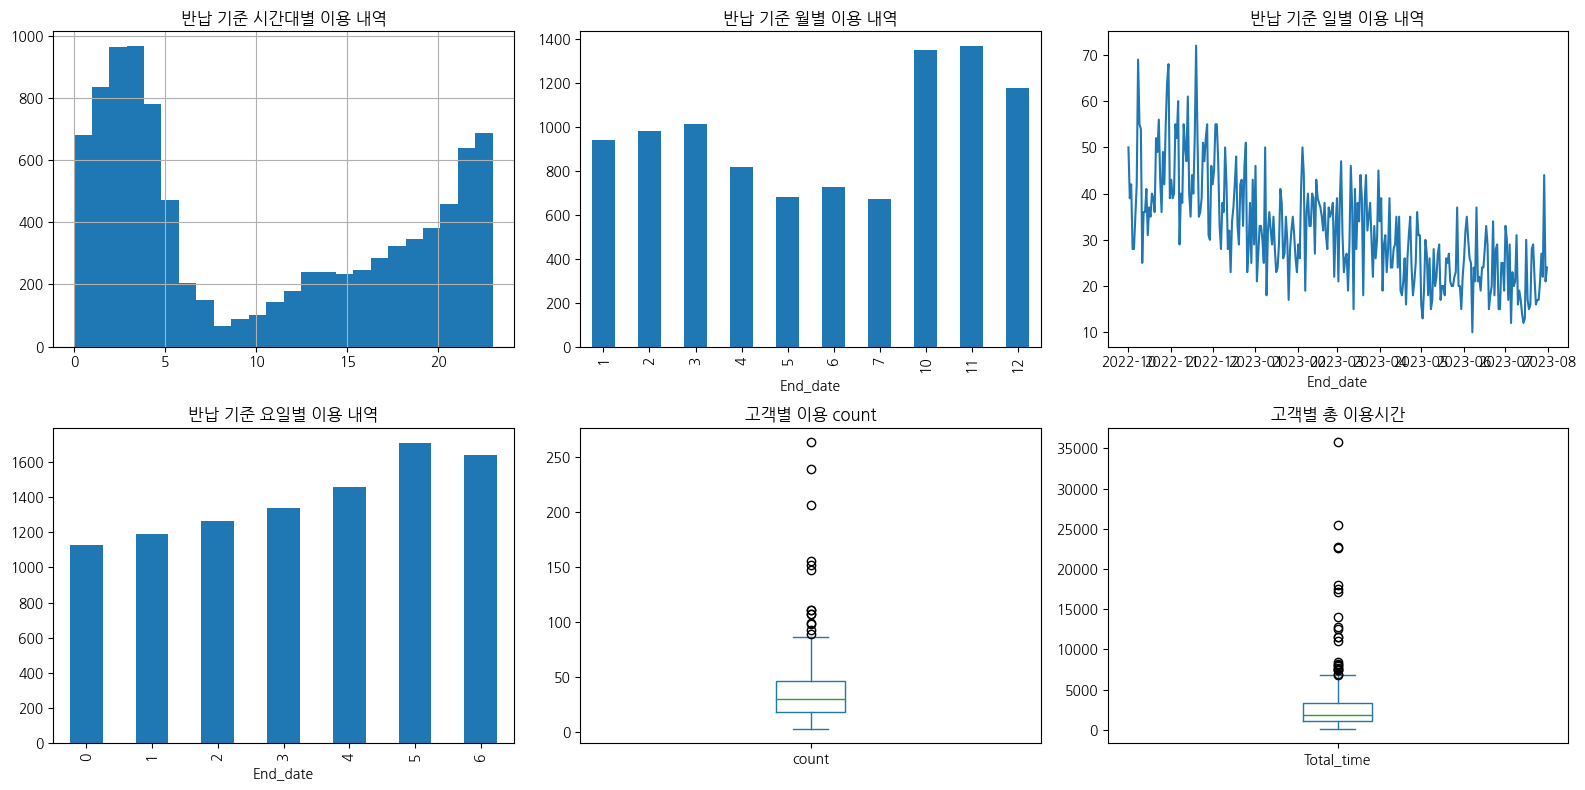

In [51]:
plot_count_datetime(df_user, designated=False, non_designated=True)


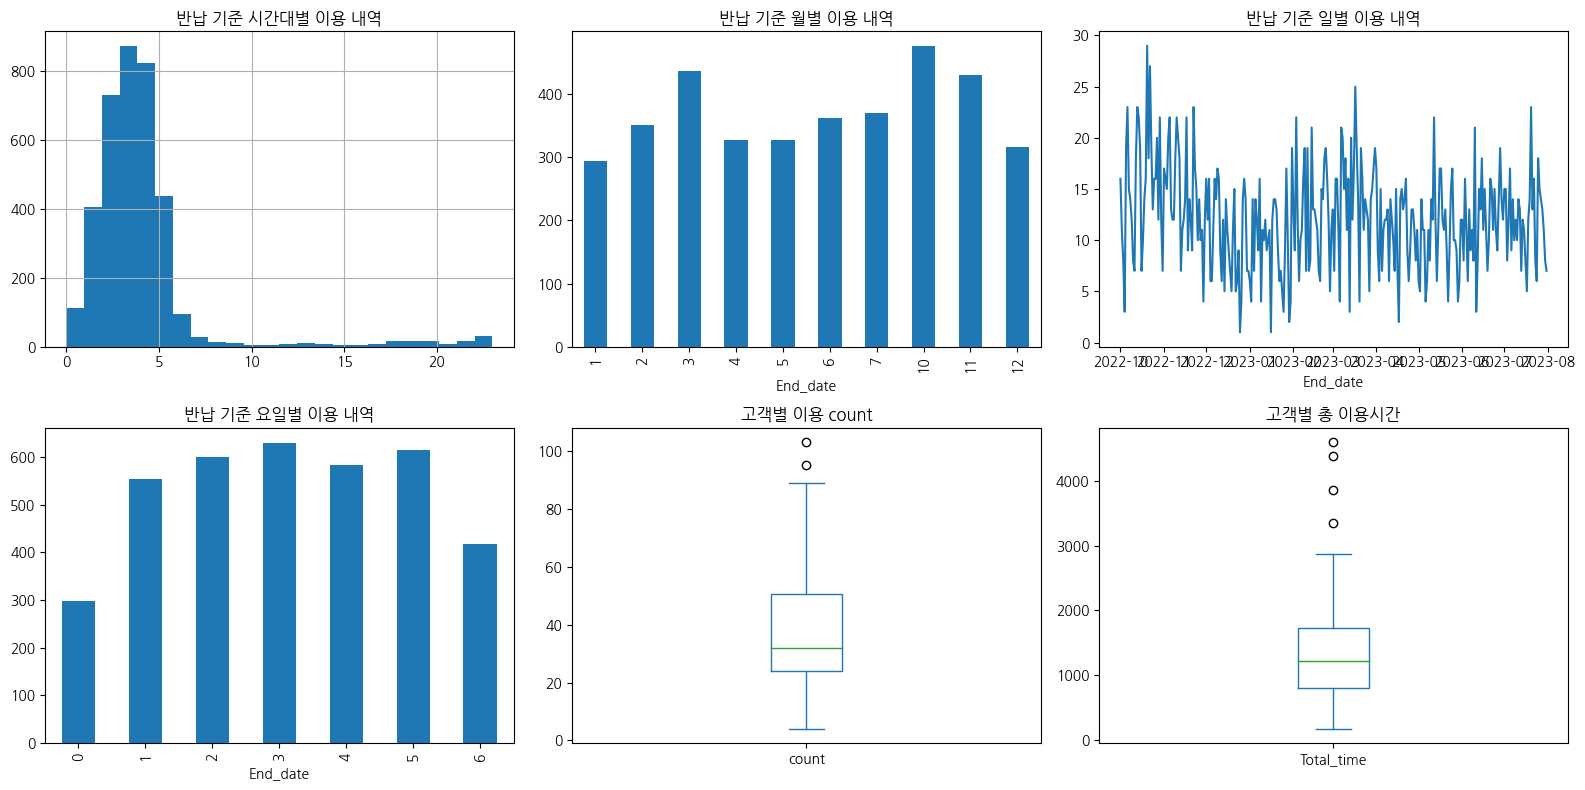

In [3]:
plot_count_datetime(df_user, designated=True, non_designated=False)

## 이용자별 데이터셋 구성

### function for `df_user_grouped`

**Dataset Restructuring**
- row, index : 각 `User_ID` 
  
- **Datetime-based Columns**
  - 시간대 이용 비율 (0~3, 3~6, ... , 21~24시 -> 6 cols for each hour group 비율) 
  - 요일별 이용 비율 (7 columns for each day)
  - 주말 이용 비율 (1 column)
- **Spot-based Usage Diversity Ratio by User**
  - 이용한 spot 다양성 (Number of unique spots / total usage count for each `User_ID`.)
  - Range : 0 ~ 1
  - near 1 : 항상 다른 spot 사용
  - near 0 : 항상 비슷한 spot 사용
- **Basic info**
  - 연령대
  - 전체 이용시간
  - 전체 이용횟수



In [3]:
def preprocess_user_grouped(df_user):
    df_user_grouped = df_user.set_index("User_ID").groupby("User_ID")
    
    # User_ID별로 주말 이용 비율 계산
    weekend_ratio = df_user_grouped["End_date"].apply(lambda x: x.dt.dayofweek.isin([5, 6]).mean()).fillna(0)
    weekend_ratio = weekend_ratio.reset_index()
    weekend_ratio.columns = ["User_ID", "Weekend_ratio"]


    # User_ID별로 요일별 이용 비율 계산
    day_ratio = df_user_grouped["End_date"].apply(lambda x: x.dt.dayofweek.value_counts(normalize=True))
    day_ratio = day_ratio.unstack().reset_index().fillna(0)
    day_ratio.columns = ["User_ID"] + [f"Day_{i}" for i in range(7)]


    # User_ID별로 시간대별 이용 비율 계산
    hour_ratio = df_user_grouped["End_date"].apply(lambda x: x.dt.hour.value_counts(normalize=True))
    hour_ratio = hour_ratio.unstack().reset_index().fillna(0)


    # 0~3, 4~7, 8~11, 12~15, 16~19, 20~23 시간대로 분류
    hour_ratio.columns = ["User_ID"] + [f"hour_{i}" for i in range(24)]

    for i in range(0, 24, 4):
        hour_ratio[f"Hour_{i}_{i+3}"] = hour_ratio[[f"hour_{j}" for j in range(i, i+4)]].sum(axis=1)

    hour_ratio.drop(columns=[f"hour_{i}" for i in range(24)], inplace=True)


    # User_ID별로 전체 이용 시간 합계
    total_time = df_user_grouped["Total_time"].sum().reset_index()
    total_time.columns = ["User_ID", "Total_time"]

    # User_ID별로 전체 이용 내역 count
    # index, column name은 spot_ratio 계산 이후 변경
    total_count = df_user["User_ID"].value_counts()


    # User_ID별로 (사용한 spot / 해당 user의 전체 이용 건수) 비율
    # start_spot_ratio, end_spot_ratio, (start, end)_spot_ratio => (start, end)는 경우의 수가 많아서 생략
    start_spot_ratio = df_user_grouped["Start_spot_ID"].nunique().sort_index()

    start_spot_ratio = start_spot_ratio / total_count
    start_spot_ratio = start_spot_ratio.reset_index()
    start_spot_ratio.columns = ["User_ID", "Start_spot_diversity"]

    end_spot_ratio = df_user_grouped["End_spot_ID"].nunique().sort_index()
    end_spot_ratio = end_spot_ratio / total_count
    end_spot_ratio = end_spot_ratio.reset_index()
    end_spot_ratio.columns = ["User_ID", "End_spot_diversity"]


    total_count = total_count.reset_index()
    total_count.columns = ["User_ID", "Total_count"]


    df_user_grouped = df_user_grouped.first().reset_index()
    df_user_grouped = df_user_grouped[["User_ID", "Age", "Gender", "Target"]]

    # Make Age and Gender into dummy
    df_user_grouped["Gender"] = df_user_grouped["Gender"].apply(lambda x: 1 if x == "남성" else 0)
    
    # rename dummy colunmns
    # Age_20 : 20 <= Age < 25
    # Age_25 : 25 <= Age < 30
    age_dummy = pd.get_dummies(pd.cut(df_user_grouped["Age"], bins=[20, 25, 30, 35, 40, 45, 50, 55, 60, 65], right=False))
    age_dummy.columns = ["Age_20", "Age_25", "Age_30", "Age_35", "Age_40", "Age_45", "Age_50", "Age_55", "Age_60"]
    df_user_grouped = pd.concat([df_user_grouped, age_dummy], axis=1)
    df_user_grouped.drop(columns="Age", inplace=True)

    # merge all dataframes with for loop
    df_list = [weekend_ratio, day_ratio, hour_ratio, total_count, total_time, 
               start_spot_ratio, end_spot_ratio]
    for df in df_list:
        df_user_grouped = df_user_grouped.merge(df, on="User_ID", how="left")
    
    return df_user_grouped

In [4]:
df_user_grouped = preprocess_user_grouped(df_user)
display(df_user_grouped.head())
print(df_user_grouped.columns)

,User_ID,Gender,Target,Age_20,Age_25,Age_30,Age_35,Age_40,Age_45,Age_50,...,Hour_0_3,Hour_4_7,Hour_8_11,Hour_12_15,Hour_16_19,Hour_20_23,Total_count,Total_time,Start_spot_diversity,End_spot_diversity
0,customer_1,1,False,True,False,False,False,False,False,False,...,0.300380,0.026616,0.049430,0.152091,0.144487,0.326996,263,17548,0.292776,0.190114
1,customer_10,1,False,False,True,False,False,False,False,False,...,0.187500,0.062500,0.000000,0.125000,0.250000,0.375000,16,948,0.562500,0.250000
2,customer_100,1,False,False,False,False,False,True,False,False,...,0.612903,0.161290,0.032258,0.129032,0.000000,0.064516,31,821,0.903226,0.193548
3,customer_101,1,True,False,False,False,False,False,True,False,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,172,1.000000,0.250000
4,customer_102,1,True,False,False,False,False,False,True,False,...,0.794872,0.153846,0.000000,0.000000,0.000000,0.051282,39,1547,0.641026,0.153846


Index(['User_ID', 'Gender', 'Target', 'Age_20', 'Age_25', 'Age_30', 'Age_35',
       'Age_40', 'Age_45', 'Age_50', 'Age_55', 'Age_60', 'Weekend_ratio',
       'Day_0', 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6',
       'Hour_0_3', 'Hour_4_7', 'Hour_8_11', 'Hour_12_15', 'Hour_16_19',
       'Hour_20_23', 'Total_count', 'Total_time', 'Start_spot_diversity',
       'End_spot_diversity'],
      dtype='object')


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

# Use several metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def print_metrics(model_name, y_test, y_pred):

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print()

def train_model(df, model_name, model, random_state=412):
    # Note that Target is binary
    
    X = df.drop(columns=["User_ID", "Target"])
    y = df["Target"]

    # split data into train and test by considering the Imbalance of Target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print_metrics(model_name, y_test, y_pred)

    return model

In [6]:
# LogisticRegression
logit = LogisticRegression(random_state=random_state, max_iter=1000, n_jobs=-1)
logit = train_model(df_user_grouped, "Logistic Regression", logit)


Model: Logistic Regression
Accuracy: 0.6901
Precision: 0.4211
Recall: 0.4211
F1: 0.4211
ROC AUC: 0.6048



In [7]:
# RandomForest
rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)
rf = train_model(df_user_grouped, "Random Forest", rf)

Model: Random Forest
Accuracy: 0.7746
Precision: 0.5882
Recall: 0.5263
F1: 0.5556
ROC AUC: 0.6959



In [8]:
# GradientBoosting
gb = GradientBoostingClassifier(random_state=random_state)
gb = train_model(df_user_grouped, "Gradient Boosting", gb)

Model: Gradient Boosting
Accuracy: 0.7746
Precision: 0.6000
Recall: 0.4737
F1: 0.5294
ROC AUC: 0.6791



In [9]:
# XGBoost
xgb = XGBClassifier(random_state=random_state, n_jobs=-1)
xgb = train_model(df_user_grouped, "XGBoost", xgb)

Model: XGBoost
Accuracy: 0.7465
Precision: 0.5263
Recall: 0.5263
F1: 0.5263
ROC AUC: 0.6766



In [10]:
# LightGBM
lgbm = LGBMClassifier(random_state=random_state, n_jobs=-1, metric="binary_logloss", objective="binary", verbose=-1)
lgbm = train_model(df_user_grouped, "LightGBM", lgbm)

Model: LightGBM
Accuracy: 0.7887
Precision: 0.6111
Recall: 0.5789
F1: 0.5946
ROC AUC: 0.7222



In [102]:
df_user.head()

,User_ID,Age,Gender,Car_number,Car_model,Fuel,Start_spot_ID,Start_spot_name,Start_spot_addr,End_spot_ID,...,End_spot_addr,Start_date,End_date,Total_time,Total_distance,Target,Start_spot_x,Start_spot_y,End_spot_x,End_spot_y
0,customer_293,50,남성,07호7029,EV6,전기,1,남산스퀘어 지상1층,서울특별시 중구 퇴계로 173,67,...,서울특별시 종로구 율곡로 53,2022-10-30 13:42:39,2022-10-30 15:23:28,100,23,False,126.991059,37.561826,126.985128,37.576600
1,customer_1,24,남성,07호7071,EV6,전기,1,남산스퀘어 지상1층,서울특별시 중구 퇴계로 173,99,...,서울특별시 성북구 화랑로13길 59,2022-10-30 18:45:20,2022-10-30 20:17:06,91,13,False,126.991059,37.561826,127.040827,37.605607
2,customer_202,24,남성,106호3082,K5,가솔린,1,남산스퀘어 지상1층,서울특별시 중구 퇴계로 173,81,...,서울특별시 영등포구 경인로 870,2022-11-17 20:54:41,2022-11-17 22:35:23,100,58,False,126.991059,37.561826,126.909283,37.516983
3,customer_202,24,남성,106호3889,니로 하이브리드,가솔린 하이브리드,1,남산스퀘어 지상1층,서울특별시 중구 퇴계로 173,30,...,서울특별시 영등포구 63로 36,2022-11-23 22:52:16,2022-11-24 01:11:58,139,54,False,126.991059,37.561826,126.938610,37.519421
4,customer_60,30,남성,106호5276,K5 하이브리드,가솔린 하이브리드,1,남산스퀘어 지상1층,서울특별시 중구 퇴계로 173,219,...,서울특별시 도봉구 도봉로 684,2022-12-18 19:35:09,2022-12-18 22:41:53,186,67,False,126.991059,37.561826,127.043607,37.665356


# EDA for job 0 or 1

In [16]:
def detailed_spot_analysis(df):
    # Target별 고유한 방문 장소 수
    unique_spots = {
        'start': df.groupby('Target')['Start_spot_ID'].nunique(),
        'end': df.groupby('Target')['End_spot_ID'].nunique()
    }
    
    # 방문 장소 집중도 (상위 5개 장소의 방문 비율)
    top_spots = {
        'start': df.groupby(['Target', 'Start_spot_name']).size().unstack(0),
        'end': df.groupby(['Target', 'End_spot_name']).size().unstack(0)
    }
    
    concentration_ratio = {}
    for spot_type in ['start', 'end']:
        concentration_ratio[spot_type] = {}
        for target in [True, False]:
            if target in top_spots[spot_type].columns:
                total_visits = top_spots[spot_type][target].sum()
                top_5_ratio = top_spots[spot_type][target].nlargest(5).sum() / total_visits
                concentration_ratio[spot_type][target] = top_5_ratio
    
    # 이동 거리 패턴
    distance_patterns = df.groupby('Target')['Total_distance'].agg(['mean', 'median', 'std'])
    
    # 시간대별 선호 패턴
    df['hour'] = pd.to_datetime(df['Start_date']).dt.hour
    time_patterns = df.groupby(['Target', 'hour']).size().unstack(0)
    peak_hours = {target: time_patterns[target].idxmax() for target in time_patterns.columns}
    
    return {
        'unique_spots': unique_spots,
        'concentration_ratio': concentration_ratio,
        'distance_patterns': distance_patterns,
        'peak_hours': peak_hours
    }

In [20]:
spot_anlysis = detailed_spot_analysis(df_user)

for k, v in spot_anlysis.items():
    print(k)
    if isinstance(v, dict):
        for k2, v2 in v.items():
            print(f"\t{k2}: {v2}")
    else:
        print(v)
    print()

unique_spots
	start: Target
False    419
True     348
Name: Start_spot_ID, dtype: int64
	end: Target
False    398
True     224
Name: End_spot_ID, dtype: int64

concentration_ratio
	start: {True: 0.09664320519761777, False: 0.07762697923092741}
	end: {True: 0.1838115863562534, False: 0.09942422373020769}

distance_patterns
             mean  median        std
Target                              
False   40.786552    30.0  54.992955
True    32.898755    30.0  19.966206

peak_hours
	False: 2
	True: 3



#### 새벽시간대만 사용

In [23]:
def extract_dawn_data(df):
    df['End_hour'] = df['End_date'].dt.hour
    dawn_data = df[df['End_hour'].between(0, 5)]
    
    return dawn_data

In [25]:
df_user_dawn = extract_dawn_data(df_user)

spot_anlysis = detailed_spot_analysis(df_user_dawn)

for k, v in spot_anlysis.items():
    print(k)
    if isinstance(v, dict):
        for k2, v2 in v.items():
            print(f"\t{k2}: {v2}")
    else:
        print(v)
    print()

unique_spots
	start: Target
False    351
True     336
Name: Start_spot_ID, dtype: int64
	end: Target
False    288
True     204
Name: End_spot_ID, dtype: int64

concentration_ratio
	start: {True: 0.09509746012994684, False: 0.08315610378562314}
	end: {True: 0.18930891907855876, False: 0.132284134410889}

distance_patterns
             mean  median        std
Target                              
False   37.789239    30.0  39.240275
True    32.134377    29.0  19.564852

peak_hours
	False: 2
	True: 3



C:\Users\82102\AppData\Local\Temp\ipykernel_16824\2722634591.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = pd.to_datetime(df['Start_date']).dt.hour
